In [1]:
import keract
import pickle
import numpy as np
import pandas as pd
from PIL import Image
# import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2, time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Convolution2D, BatchNormalization, ReLU,LeakyReLU,Add, Activation, Conv2DTranspose, MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, UpSampling2D, Input, Dropout, ZeroPadding2D, Concatenate
import tensorflow_addons as tfa

C:\Users\Owner\anaconda3\envs\TensorFlow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Owner\anaconda3\envs\TensorFlow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [2]:
print(tf.__version__)

2.10.1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e: 
        # Memory growth must be set before GPUs have been initialized
        print(e)        

1 Physical GPUs, 1 Logical GPUs


In [4]:
train_images = "./datasets/input/train_image2/"
train_masks = "./datasets/input/train_mask2/"
val_images = "./datasets/input/val_image2/"
val_masks = "./datasets/input/val_mask2/"
test_images = "./datasets/input/test_image2/"
test_masks = "./datasets/input/test_mask2/"

num_classes = 6
input_size = (256, 256, 3)
image_size = (256, 256)
batch_size = 8

In [5]:
class_dict_df = pd.read_csv('./datasets/input/class_dict.csv', index_col=False, skipinitialspace=True)
class_dict_df

,name,r,g,b
0,building,60,16,152
1,land,132,41,246
2,road,110,193,228
3,vegetation,254,221,58
4,water,226,169,41
5,unlabeled,155,155,155


In [6]:
label_names= list(class_dict_df.name)
label_codes = []
r= np.asarray(class_dict_df.r)
g= np.asarray(class_dict_df.g)
b= np.asarray(class_dict_df.b)

for i in range(len(class_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
label_codes, label_names

([(60, 16, 152),
  (132, 41, 246),
  (110, 193, 228),
  (254, 221, 58),
  (226, 169, 41),
  (155, 155, 155)],
 ['building', 'land', 'road', 'vegetation', 'water', 'unlabeled'])

In [7]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [8]:
id2code, id2name

({0: (60, 16, 152),
  1: (132, 41, 246),
  2: (110, 193, 228),
  3: (254, 221, 58),
  4: (226, 169, 41),
  5: (155, 155, 155)},
 {0: 'building',
  1: 'land',
  2: 'road',
  3: 'vegetation',
  4: 'water',
  5: 'unlabeled'})

In [9]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape((-1,3)) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2] + (3,))
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [10]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

In [11]:
def TrainAugmentGenerator(train_images_dir, train_masks_dir, seed = 1, batch_size = batch_size, target_size = image_size):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            train_images_dir - train images directory
            train_masks_dir - train masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    train_images_dir,
    batch_size = batch_size,
    color_mode = 'rgb',
    #color_mode = 'grayscale', #흑백사진 일 경우
    seed = seed, 
    target_size = target_size)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    train_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
          
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(val_images_dir, val_masks_dir, seed = 1, batch_size = batch_size, target_size = image_size):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            val_images_dir - validation images directory
            val_masks_dir - validation masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    val_images_dir,
    batch_size = batch_size,
    color_mode = 'rgb',
    #color_mode = 'grayscale', #흑백사진 일 경우
    seed = seed, 
    target_size = target_size)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    val_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
#         print(f'mask_encoded: {np.asarray(mask_encoded)}')
        
        yield X1i[0], np.asarray(mask_encoded)

In [12]:
num_train_samples = len(np.sort(os.listdir(train_images + "images/")))
num_val_samples = len(np.sort(os.listdir(val_images + "images/")))
steps_per_epoch = np.ceil(float(num_train_samples) / float(batch_size)/5)
print('steps_per_epoch: ', steps_per_epoch)
validation_steps = np.ceil(float(4 * num_val_samples) / float(batch_size)/5)
print('validation_steps: ', validation_steps)

steps_per_epoch:  18.0
validation_steps:  22.0


In [13]:
def multi_link_block(orginal_inputs, add_inputs1, add_inputs2, num_filters):
    original_inputs = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(orginal_inputs)
    add_inputs2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(add_inputs2)
    concat = Concatenate()([original_inputs, add_inputs1, add_inputs2])
    x = Convolution2D(num_filters, 3, padding="same")(concat)
    return x

def build_model(input_shape):
    """ Input """
    inputs = Input(input_shape)
    """ Pre-trained NetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)
    
    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (256 x 256)

    s2 = encoder.get_layer("activation_2").output      ## (125 x 125)
    s2 = ZeroPadding2D(((2, 1),(2, 1)))(s2)            ## (128 x 128)

    s3 = encoder.get_layer("activation_4").output      ## (60 x 60)
    s3 = ZeroPadding2D((2, 2))(s3)                     ## (64 x 64)

    s4 = encoder.get_layer("activation_74").output      ## (29 x 29)
    s4 = ZeroPadding2D(((2, 1),(2, 1)))(s4)             ## (32 x 32)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (14 x 14)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (16 x 16)
    
    """ Decoder """
    x = multi_link_block(b1, s4, s3, 128)
    x = multi_link_block(x, s3, s2, 64)
    x = multi_link_block(x, s2, s1, 32)
    
    """ Connected """
    x = Conv2DTranspose(16, (2, 2), strides=2, padding="same")(x)
    s1 = Convolution2D(16, 3, padding="same")(s1)
    
    outputs = Concatenate()([x, s1])
    
    return inputs, outputs

In [14]:
def last_conv_module(input_shape):
    inputs, X = build_model(input_shape)
    X = Convolution2D(filters=3, kernel_size=3, padding='same')(X)
    X = BatchNormalization()(X)
    # dropout = Dropout(0.3)(X)
    outputs = Convolution2D(num_classes, 1, padding="same", activation="softmax")(X)
    
    model = Model(inputs, outputs, name="InceptionResNetV2")
    return model

In [15]:
K.clear_session()

def dice_coef(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

# ship detection = class 2개일 때 클래스 불균형 확인차 iou 2개(metrics=[iou0, iou1, dice_coef, "accuracy"]) 설정
# 다중 클래스일 경우, mean iou 사용

def mean_iou(y_true, y_pred, num_classes = 6):
    """
    Calculate the mean IoU across all classes.
    Args:
        y_true: the expected y values as a one-hot encoded tensor
        y_pred: the predicted y values as a one-hot or softmax tensor
        num_classes: total number of classes
    Returns:
        mean IoU across all classes
    """
    ious = []
    y_true = K.argmax(y_true, axis=-1)  # 라벨 인코딩으로 변환
    y_pred = K.argmax(y_pred, axis=-1)  # 예측값 인코딩으로 변환

    for label in range(num_classes):
        y_true_label = K.cast(K.equal(y_true, label), K.floatx())
        y_pred_label = K.cast(K.equal(y_pred, label), K.floatx())
        
        # Intersection과 Union 계산
        intersection = K.sum(y_true_label * y_pred_label)
        union = K.sum(y_true_label) + K.sum(y_pred_label) - intersection
        
        # IoU 계산 (divide by zero 방지)
        iou = K.switch(K.equal(union, 0), 1.0, intersection / union)
        ious.append(iou)
    
    # 모든 클래스의 IoU 평균
    mean_iou = K.mean(K.stack(ious), axis=0)
    
    return mean_iou

In [16]:
model = last_conv_module(input_shape = (256, 256, 3))

In [32]:
model.compile(optimizer=Adam(
    learning_rate = 0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=[mean_iou, dice_coef, "accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_209 (Conv2D)            (None, 128, 128, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_204 (Batch  (None, 128, 128, 32  96         ['conv2d_209[0][0]']             
 Normalization)                 )                                                             

 batch_normalization_209 (Batch  (None, 32, 32, 96)  288         ['conv2d_214[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_211 (Batch  (None, 32, 32, 64)  192         ['conv2d_216[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_214 (Batch  (None, 32, 32, 96)  288         ['conv2d_219[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_215 (Batch  (None, 32, 32, 64)  192         ['conv2d_220[0][0]']             
 Normaliza

 activation_224 (Activation)    (None, 32, 32, 32)   0           ['batch_normalization_225[0][0]']
                                                                                                  
 conv2d_228 (Conv2D)            (None, 32, 32, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_231 (Conv2D)            (None, 32, 32, 48)   13824       ['activation_224[0][0]']         
                                                                                                  
 batch_normalization_223 (Batch  (None, 32, 32, 32)  96          ['conv2d_228[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_226 (Batch  (None, 32, 32, 48)  144         ['conv2d_231[0][0]']             
 Normaliza

                                                                                                  
 activation_227 (Activation)    (None, 32, 32, 32)   0           ['batch_normalization_228[0][0]']
                                                                                                  
 activation_229 (Activation)    (None, 32, 32, 32)   0           ['batch_normalization_230[0][0]']
                                                                                                  
 activation_232 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_233[0][0]']
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 32, 32, 128)  0           ['activation_227[0][0]',         
                                                                  'activation_229[0][0]',         
                                                                  'activation_232[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_244 (Batch  (None, 32, 32, 48)  144         ['conv2d_249[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_240 (Activation)    (None, 32, 32, 32)   0           ['batch_normalization_241[0][0]']
                                                                                                  
 activation_243 (Activation)    (None, 32, 32, 48)   0           ['batch_normalization_244[0][0]']
                                                                                                  
 conv2d_245 (Conv2D)            (None, 32, 32, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 32, 32, 128)  0           ['activation_245[0][0]',         
                                                                  'activation_247[0][0]',         
                                                                  'activation_250[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 32, 32, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 32, 32, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 32, 32, 320)  0           ['block35_6[0][0]']              
          

 activation_261 (Activation)    (None, 32, 32, 48)   0           ['batch_normalization_262[0][0]']
                                                                                                  
 conv2d_263 (Conv2D)            (None, 32, 32, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_265 (Conv2D)            (None, 32, 32, 32)   9216        ['activation_258[0][0]']         
                                                                                                  
 conv2d_268 (Conv2D)            (None, 32, 32, 64)   27648       ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_258 (Batch  (None, 32, 32, 32)  96          ['conv2d_263[0][0]']             
 Normalization)                                                                                   
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 32, 32, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_278 (Conv2D)            (None, 32, 32, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_273 (Batch  (None, 32, 32, 32)  96          ['conv2d_278[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_272 (Activation)    (None, 32, 32, 32)   0           ['batch_normalization_273[0][0]']
          

 activation_278 (Activation)    (None, 16, 16, 384)  0           ['batch_normalization_279[0][0]']
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 16, 16, 1088  0           ['activation_275[0][0]',         
                                )                                 'activation_278[0][0]',         
                                                                  'max_pooling2d_9[0][0]']        
                                                                                                  
 conv2d_286 (Conv2D)            (None, 16, 16, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 16, 16, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_294 (Conv2D)            (None, 16, 16, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_289 (Batch  (None, 16, 16, 128)  384        ['conv2d_294[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_302 (Conv2D)            (None, 16, 16, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_297 (Batch  (None, 16, 16, 128)  384        ['conv2d_302[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_296 (Activation)    (None, 16, 16, 128)  0           ['batch_normalization_297[0][0]']
                                                                                                  
 conv2d_303 (Conv2D)            (None, 16, 16, 160)  143360      ['activation_296[0][0]']         
          

                                                                                                  
 batch_normalization_305 (Batch  (None, 16, 16, 128)  384        ['conv2d_310[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_304 (Activation)    (None, 16, 16, 128)  0           ['batch_normalization_305[0][0]']
                                                                                                  
 conv2d_311 (Conv2D)            (None, 16, 16, 160)  143360      ['activation_304[0][0]']         
                                                                                                  
 batch_normalization_306 (Batch  (None, 16, 16, 160)  480        ['conv2d_311[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_312 (Activation)    (None, 16, 16, 128)  0           ['batch_normalization_313[0][0]']
                                                                                                  
 conv2d_319 (Conv2D)            (None, 16, 16, 160)  143360      ['activation_312[0][0]']         
                                                                                                  
 batch_normalization_314 (Batch  (None, 16, 16, 160)  480        ['conv2d_319[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_313 (Activation)    (None, 16, 16, 160)  0           ['batch_normalization_314[0][0]']
                                                                                                  
 conv2d_31

 conv2d_327 (Conv2D)            (None, 16, 16, 160)  143360      ['activation_320[0][0]']         
                                                                                                  
 batch_normalization_322 (Batch  (None, 16, 16, 160)  480        ['conv2d_327[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_321 (Activation)    (None, 16, 16, 160)  0           ['batch_normalization_322[0][0]']
                                                                                                  
 conv2d_325 (Conv2D)            (None, 16, 16, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_328 (Conv2D)            (None, 16, 16, 192)  215040      ['activation_321[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_329 (Activation)    (None, 16, 16, 160)  0           ['batch_normalization_330[0][0]']
                                                                                                  
 conv2d_333 (Conv2D)            (None, 16, 16, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_336 (Conv2D)            (None, 16, 16, 192)  215040      ['activation_329[0][0]']         
                                                                                                  
 batch_normalization_328 (Batch  (None, 16, 16, 192)  576        ['conv2d_333[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_341 (Conv2D)            (None, 16, 16, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_344 (Conv2D)            (None, 16, 16, 192)  215040      ['activation_337[0][0]']         
                                                                                                  
 batch_normalization_336 (Batch  (None, 16, 16, 192)  576        ['conv2d_341[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_339 (Batch  (None, 16, 16, 192)  576        ['conv2d_344[0][0]']             
 Normalization)                                                                                   
          

 conv2d_352 (Conv2D)            (None, 16, 16, 192)  215040      ['activation_345[0][0]']         
                                                                                                  
 batch_normalization_344 (Batch  (None, 16, 16, 192)  576        ['conv2d_349[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_347 (Batch  (None, 16, 16, 192)  576        ['conv2d_352[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_343 (Activation)    (None, 16, 16, 192)  0           ['batch_normalization_344[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_355 (Batch  (None, 16, 16, 192)  576        ['conv2d_360[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_351 (Activation)    (None, 16, 16, 192)  0           ['batch_normalization_352[0][0]']
                                                                                                  
 activation_354 (Activation)    (None, 16, 16, 192)  0           ['batch_normalization_355[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 16, 16, 384)  0          ['activation_351[0][0]',         
          

 activation_359 (Activation)    (None, 16, 16, 256)  0           ['batch_normalization_360[0][0]']
                                                                                                  
 activation_361 (Activation)    (None, 16, 16, 256)  0           ['batch_normalization_362[0][0]']
                                                                                                  
 activation_364 (Activation)    (None, 16, 16, 288)  0           ['batch_normalization_365[0][0]']
                                                                                                  
 conv2d_366 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_359[0][0]']         
                                                                                                  
 conv2d_368 (Conv2D)            (None, 8, 8, 288)    663552      ['activation_361[0][0]']         
                                                                                                  
 conv2d_37

 Normalization)                                                                                   
                                                                                                  
 activation_372 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_373[0][0]']
                                                                                                  
 conv2d_376 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_379 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_372[0][0]']         
                                                                                                  
 batch_normalization_371 (Batch  (None, 8, 8, 192)   576         ['conv2d_376[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 batch_normalization_379 (Batch  (None, 8, 8, 192)   576         ['conv2d_384[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_382 (Batch  (None, 8, 8, 256)   768         ['conv2d_387[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_378 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_379[0][0]']
                                                                                                  
 activation_381 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_382[0][0]']
          

 activation_386 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_387[0][0]']
                                                                                                  
 activation_389 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_390[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_386[0][0]',         
                                                                  'activation_389[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 8, 8, 2080)   0           ['block8_5_ac[0][0]',            
          

 block8_8_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_8_mixed[0][0]']         
                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_405 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_400 (Batch  (None, 8, 8, 192)   576         ['conv2d_405[0][0]']             
 Normaliza

 conv_7b_bn (BatchNormalization  (None, 8, 8, 1536)  4608        ['conv_7b[0][0]']                
 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 8, 8, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 decoder_stage0_upsampling (UpS  (None, 16, 16, 1536  0          ['conv_7b_ac[0][0]']             
 ampling2D)                     )                                                                 
                                                                                                  
 decoder_stage0_concat (Concate  (None, 16, 16, 2624  0          ['decoder_stage0_upsampling[0][0]
 nate)                          )                                ',                               
          

                                                                                                  
 decoder_stage3a_bn (BatchNorma  (None, 128, 128, 32  128        ['decoder_stage3a_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage3a_relu (Activati  (None, 128, 128, 32  0          ['decoder_stage3a_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_stage3b_conv (Conv2D)  (None, 128, 128, 32  9216        ['decoder_stage3a_relu[0][0]']   
                                )                                                                 
                                                                                                  
 decoder_s

In [33]:
def exponential_decay(lr0, s, warmup_epochs=10, min_lr=1e-6):
    """
    Exponential Decay Learning Rate Scheduler with Warmup and Minimum Learning Rate.
    
    Args:
        lr0: float, initial learning rate.
        s: float, decay step (controls the rate of decay).
        warmup_epochs: int, number of epochs to keep the initial learning rate constant.
        min_lr: float, minimum learning rate after decay.
    
    Returns:
        A function that computes the learning rate based on the current epoch.
    """
    def exponential_decay_fn(epoch):
        if epoch < warmup_epochs:
            return lr0  # Warmup: Keep initial learning rate for `warmup_epochs`
        lr = lr0 * 0.1 ** ((epoch - warmup_epochs) / s)
        return max(lr, min_lr)  # Ensure learning rate does not go below `min_lr`
    
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'kics_summer_model.h5',
    save_best_only = True, 
#   save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "kics_summer_model.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [34]:
a, b = next(TrainAugmentGenerator(train_images_dir = train_images, train_masks_dir = train_masks, batch_size = batch_size, target_size = image_size))

Found 710 images belonging to 1 classes.
Found 710 images belonging to 1 classes.


In [35]:
history = model.fit(
    TrainAugmentGenerator(train_images_dir = train_images, train_masks_dir = train_masks, batch_size = batch_size, target_size = image_size), 
    steps_per_epoch=steps_per_epoch,
    validation_data = ValAugmentGenerator(val_images_dir = val_images, val_masks_dir = val_masks, batch_size = batch_size, target_size = image_size), 
    validation_steps = validation_steps, 
    epochs = 200,
    callbacks=callbacks,
    use_multiprocessing=False,
    verbose=1
)

Found 710 images belonging to 1 classes.
Found 710 images belonging to 1 classes.

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/200
18/18 [==============================] - ETA: 0s - loss: 1.3845 - mean_iou: 0.2203 - dice_coef: 0.3351 - accuracy: 0.4941Found 213 images belonging to 1 classes.
Found 213 images belonging to 1 classes.

Epoch 1: val_loss improved from inf to 83.16804, saving model to kics_summer_model.h5
18/18 [==============================] - 17s 405ms/step - loss: 1.3845 - mean_iou: 0.2203 - dice_coef: 0.3351 - accuracy: 0.4941 - val_loss: 83.1680 - val_mean_iou: 0.0410 - val_dice_coef: 0.1217 - val_accuracy: 0.1228 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 0.8362 - mean_iou: 0.3473 - dice_coef: 0.5601 - accuracy: 0.7172
Epoch 2: val_loss did not improve from 83.16804
18/18 [==============================] - 3s 192ms/step - loss: 0.8362 - me

Epoch 17/200
18/18 [==============================] - ETA: 0s - loss: 0.5167 - mean_iou: 0.5324 - dice_coef: 0.7331 - accuracy: 0.8180
Epoch 17: val_loss improved from 0.58569 to 0.53632, saving model to kics_summer_model.h5
18/18 [==============================] - 5s 289ms/step - loss: 0.5167 - mean_iou: 0.5324 - dice_coef: 0.7331 - accuracy: 0.8180 - val_loss: 0.5363 - val_mean_iou: 0.4860 - val_dice_coef: 0.7432 - val_accuracy: 0.8145 - lr: 7.9433e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0007644222742526003.
Epoch 18/200
18/18 [==============================] - ETA: 0s - loss: 0.4563 - mean_iou: 0.5645 - dice_coef: 0.7585 - accuracy: 0.8386
Epoch 18: val_loss did not improve from 0.53632
18/18 [==============================] - 3s 194ms/step - loss: 0.4563 - mean_iou: 0.5645 - dice_coef: 0.7585 - accuracy: 0.8386 - val_loss: 0.5920 - val_mean_iou: 0.4760 - val_dice_coef: 0.7270 - val_accuracy: 0.7877 - lr: 7.6442e-04

Epoch 19: LearningRateScheduler setting le

Epoch 33/200
18/18 [==============================] - ETA: 0s - loss: 0.3785 - mean_iou: 0.5923 - dice_coef: 0.8025 - accuracy: 0.8666
Epoch 33: val_loss improved from 0.38647 to 0.38540, saving model to kics_summer_model.h5
18/18 [==============================] - 5s 281ms/step - loss: 0.3785 - mean_iou: 0.5923 - dice_coef: 0.8025 - accuracy: 0.8666 - val_loss: 0.3854 - val_mean_iou: 0.5830 - val_dice_coef: 0.7990 - val_accuracy: 0.8596 - lr: 4.2987e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0004136820402388507.
Epoch 34/200
18/18 [==============================] - ETA: 0s - loss: 0.3633 - mean_iou: 0.5958 - dice_coef: 0.8042 - accuracy: 0.8707
Epoch 34: val_loss did not improve from 0.38540
18/18 [==============================] - 3s 190ms/step - loss: 0.3633 - mean_iou: 0.5958 - dice_coef: 0.8042 - accuracy: 0.8707 - val_loss: 0.3962 - val_mean_iou: 0.5766 - val_dice_coef: 0.7921 - val_accuracy: 0.8553 - lr: 4.1368e-04

Epoch 35: LearningRateScheduler setting le

18/18 [==============================] - ETA: 0s - loss: 0.3001 - mean_iou: 0.6327 - dice_coef: 0.8352 - accuracy: 0.8931
Epoch 49: val_loss did not improve from 0.31671
18/18 [==============================] - 3s 190ms/step - loss: 0.3001 - mean_iou: 0.6327 - dice_coef: 0.8352 - accuracy: 0.8931 - val_loss: 0.3350 - val_mean_iou: 0.6029 - val_dice_coef: 0.8258 - val_accuracy: 0.8790 - lr: 2.3263e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.00022387211385683394.
Epoch 50/200
18/18 [==============================] - ETA: 0s - loss: 0.3130 - mean_iou: 0.6294 - dice_coef: 0.8309 - accuracy: 0.8857
Epoch 50: val_loss did not improve from 0.31671
18/18 [==============================] - 3s 188ms/step - loss: 0.3130 - mean_iou: 0.6294 - dice_coef: 0.8309 - accuracy: 0.8857 - val_loss: 0.3373 - val_mean_iou: 0.6094 - val_dice_coef: 0.8260 - val_accuracy: 0.8769 - lr: 2.2387e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0002154434690031884.
Epoch 51/200
18/

18/18 [==============================] - ETA: 0s - loss: 0.2678 - mean_iou: 0.6493 - dice_coef: 0.8512 - accuracy: 0.9020
Epoch 65: val_loss did not improve from 0.30416
18/18 [==============================] - 3s 189ms/step - loss: 0.2678 - mean_iou: 0.6493 - dice_coef: 0.8512 - accuracy: 0.9020 - val_loss: 0.3114 - val_mean_iou: 0.6269 - val_dice_coef: 0.8470 - val_accuracy: 0.8868 - lr: 1.2589e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.00012115276586285887.
Epoch 66/200
18/18 [==============================] - ETA: 0s - loss: 0.2520 - mean_iou: 0.6472 - dice_coef: 0.8575 - accuracy: 0.9040
Epoch 66: val_loss did not improve from 0.30416
18/18 [==============================] - 3s 190ms/step - loss: 0.2520 - mean_iou: 0.6472 - dice_coef: 0.8575 - accuracy: 0.9040 - val_loss: 0.3246 - val_mean_iou: 0.6265 - val_dice_coef: 0.8356 - val_accuracy: 0.8835 - lr: 1.2115e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.00011659144011798318.
Epoch 67/200
18

18/18 [==============================] - ETA: 0s - loss: 0.2492 - mean_iou: 0.6494 - dice_coef: 0.8605 - accuracy: 0.9038
Epoch 81: val_loss did not improve from 0.28904
18/18 [==============================] - 3s 190ms/step - loss: 0.2492 - mean_iou: 0.6494 - dice_coef: 0.8605 - accuracy: 0.9038 - val_loss: 0.2956 - val_mean_iou: 0.6285 - val_dice_coef: 0.8540 - val_accuracy: 0.8911 - lr: 6.8129e-05

Epoch 82: LearningRateScheduler setting learning rate to 6.556418494179789e-05.
Epoch 82/200
18/18 [==============================] - ETA: 0s - loss: 0.2278 - mean_iou: 0.6703 - dice_coef: 0.8702 - accuracy: 0.9125
Epoch 82: val_loss improved from 0.28904 to 0.28709, saving model to kics_summer_model.h5
18/18 [==============================] - 5s 289ms/step - loss: 0.2278 - mean_iou: 0.6703 - dice_coef: 0.8702 - accuracy: 0.9125 - val_loss: 0.2871 - val_mean_iou: 0.6321 - val_dice_coef: 0.8542 - val_accuracy: 0.8930 - lr: 6.5564e-05

Epoch 83: LearningRateScheduler setting learning rate t

18/18 [==============================] - 3s 190ms/step - loss: 0.2023 - mean_iou: 0.6862 - dice_coef: 0.8849 - accuracy: 0.9224 - val_loss: 0.2993 - val_mean_iou: 0.6415 - val_dice_coef: 0.8536 - val_accuracy: 0.8912 - lr: 3.6869e-05

Epoch 98: LearningRateScheduler setting learning rate to 3.5481338923357554e-05.
Epoch 98/200
18/18 [==============================] - ETA: 0s - loss: 0.2152 - mean_iou: 0.6799 - dice_coef: 0.8772 - accuracy: 0.9185
Epoch 98: val_loss did not improve from 0.28127
18/18 [==============================] - 3s 188ms/step - loss: 0.2152 - mean_iou: 0.6799 - dice_coef: 0.8772 - accuracy: 0.9185 - val_loss: 0.2867 - val_mean_iou: 0.6343 - val_dice_coef: 0.8626 - val_accuracy: 0.8960 - lr: 3.5481e-05

Epoch 99: LearningRateScheduler setting learning rate to 3.414548873833603e-05.
Epoch 99/200
18/18 [==============================] - ETA: 0s - loss: 0.2371 - mean_iou: 0.6814 - dice_coef: 0.8663 - accuracy: 0.9081
Epoch 99: val_loss did not improve from 0.28127
18/

In [36]:
model.load_weights("./kics_summer_model.h5")

In [37]:
testing_gen = ValAugmentGenerator(val_images_dir = test_images, val_masks_dir = test_masks, batch_size = batch_size, target_size = image_size)

In [38]:
results = model.evaluate(
    testing_gen,
    batch_size = batch_size,
    steps=50,
    verbose=1,
    callbacks=callbacks,
)

Found 213 images belonging to 1 classes.
Found 213 images belonging to 1 classes.
50/50 [==============================] - 4s 79ms/step - loss: 0.2964 - mean_iou: 0.6362 - dice_coef: 0.8526 - accuracy: 0.8914


In [39]:
print("test loss, IoU, dice_coef, test acc:", results)

test loss, IoU, dice_coef, test acc: [0.29641783237457275, 0.6362375617027283, 0.8525645732879639, 0.8913767337799072]


1/1 [==============================] - 0s 29ms/step


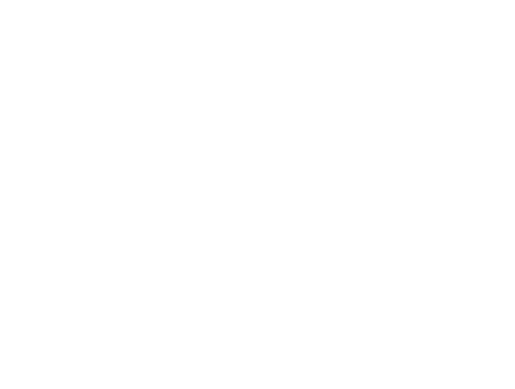

In [40]:
for i in range(8):
    # 배치에서 이미지와 마스크를 가져옴
    batch_img, batch_mask = next(testing_gen)
    pred_all = model.predict(batch_img)
#     print("Predictions Shape:", np.shape(pred_all))  # (batch_size, height, width, num_classes)

    # 예측 마스크 저장
    plt.axis('off')
    plt.imsave('./예측사진/2%02d_Pmask.png' % i, onehot_to_rgb(pred_all[i], id2code))

    # 배치 이미지를 저장할 때, 채널 축 확인
    if batch_img.shape[-1] == 3:  # RGB 이미지인 경우
        plt.imsave('./예측사진/2%02d_image.png' % i, batch_img[i])  # cmap 제거
    elif batch_img.shape[-1] == 1:  # Grayscale 이미지인 경우
        plt.imsave('./예측사진/2%02d_image.png' % i, batch_img[i].squeeze(), cmap='gray')

    # 정답 마스크 저장
    plt.imsave('./예측사진/2%02d_Tmask.png' % i, onehot_to_rgb(batch_mask[i], id2code))